# Reproduce : A Deep Learning Framework for Optimization of MISO Downlink Beamforming

## SINR Balancing

### Data Generation

From "Solution of the Multiuser Downlink Beamforming
Problem With Individual SINR Constraints" - Table 1

In [1]:
import numpy as np

np.random.seed(12)

def steering_vector_ula(theta_rad, M, d, wavelength):
    m = np.arange(M)
    phase = -1j * 2 * np.pi * d / wavelength * m * np.sin(theta_rad)
    a_theta = np.exp(phase) / np.sqrt(M)  # 정규화
    return a_theta  # shape (M,)

def make_user_channel_geometric(M, L, user_center_deg,
                                aoa_spread_deg=1,
                                pathloss_mean_db=-8,
                                pathloss_std_db=3,
                                wavelength=1.0,
                                d=None):
    if d is None:
        d = wavelength / 2  # λ/2 간격
    
    h = np.zeros(M, dtype=np.complex128)

    for _ in range(L):
        # 1) 방위각: 중심각 +/- 산란
        aoa_deg = user_center_deg + np.random.normal(0.0, aoa_spread_deg)
        aoa_rad = np.deg2rad(aoa_deg)

        # 2) 개별 경로 감쇠 (path loss) + 위상
        pl_db = np.random.normal(pathloss_mean_db, pathloss_std_db)
        amp = 10**(pl_db / 20.0)  # dB -> amplitude
        phase = np.random.uniform(0, 2*np.pi)
        alpha = amp * np.exp(1j * phase)

        # 3) 배열 응답
        a_theta = steering_vector_ula(aoa_rad, M, d, wavelength)

        # 4) 경로 누적
        h += alpha * a_theta

    return h  # shape (M,)

def sample_user_centers(K, sector_deg=120.0):
    # 균등분포된 방위각 (uniform azimuth pdf)
    return np.random.uniform(-sector_deg/2, sector_deg/2, size=K)

# -----------------------------
# 시뮬레이션 파라미터
# -----------------------------
K = 5      # 사용자 수
M = 4      # BS 안테나 수 (ULA elements)
L = 20

# 경로 수 (multipaths per user)
sector_deg = 120.0
wavelength = 1.0
d = wavelength / 2.0

# 사용자 방위각 샘플링
user_centers_deg = sample_user_centers(K, sector_deg=sector_deg)  # shape (K,)

# 채널 행렬 H (K x M)
H = np.zeros((K, M), dtype=np.complex128)

for k in range(K):
    h_k = make_user_channel_geometric(
        M=M,
        L=L,
        user_center_deg=user_centers_deg[k],
        aoa_spread_deg=0.0,        # azimuth dispersion
        pathloss_mean_db=-3,       # 평균 path 강도
        pathloss_std_db=1,         # 경로별 강도 편차
        wavelength=wavelength,
        d=d
    )

    # 선택적으로 정규화(알고리즘이 안 무너지게 하기 위해 자주 씀):
    # 유저별 채널 파워를 맞춰주면 max-min SINR 알고리즘이 덜 극단적으로 깨집니다.
    # h_k = h_k / np.linalg.norm(h_k) * np.sqrt(M)

    H[k, :] = h_k
    
sigma2 = (np.random.normal(loc=1.0, scale=0.4, size=K))**2 * 1e-13
# sigma2 = np.full(K, 1.0)  # 모든 사용자 동일 노이즈

# sigma2 = np.ones(K)
R = [H[i].reshape(-1,1) @ H[i].conj().reshape(1,-1) for i in range(K)]  # 상관행렬
U = np.zeros((M, K), dtype=np.complex128)
I = np.eye(M, dtype=np.complex128)

In [189]:
import numpy as np
# 1 initialization
n = 0
q_ext = np.zeros(K)

Pmax_dbm = 30     # 총 전력 30 dBm
Pmax = 10**((Pmax_dbm - 30)/10.0)  # 1 W
 
lam_new = 0.0
epsilon = 1e-6 # 수렴 조건

# 2 채널 행렬을 잡음 전력으로 정규화 : downlink
R_tilde = [R[i] / sigma2[i] for i in range(K)]

# 3 잡음 전력을 1로 정규화 : virtual uplink의 정의에 따라
sigma2_virtual = np.ones(K) # 노이즈 파워
 
# 4 목표 SINR 설정
target_sinr_db = 5   # 10 dB
gamma = np.ones(K) * 10**(target_sinr_db / 20)

# 반복문
max_iter = 100
while n < max_iter:
    
    # 5 반복 카운터 증가
    n += 1
    
    # 6 사용자 별 수신기 벡터 ui를 고유벡터로 업데이트 : Beamforming Step
    
    # 최대 고유값에 대응하는 고유벡터를 반환해서 수신 beamforming 벡터로 사용 (uplink이기 때문)
    # 이 떄 q는 고정 (논문 식 30,31 참고)
    for i in range(K):   
        # Q_i 계산
        Q_i = I.copy()
        for k in range(K):
            if k != i:
                Q_i += q_ext[k] * R_tilde[k]

        # Generalized Eigenvalue 문제 풀이
        A = np.linalg.solve(Q_i, R_tilde[i])
        eigvals, eigvecs = np.linalg.eig(A)
        u_i = eigvecs[:, np.argmax(np.real(eigvals))]
        
        # 7 수신 벡터 ui 정규화
        U[:, i] = u_i / np.linalg.norm(u_i)
    
    # --- 성능 시각화 ---
    SINR_UL_iter = np.zeros(K, dtype=float)
    for k in range(K):
        uk = U[:, k]
        num = q_ext[k] * np.real(uk.conj().T @ R_tilde[k] @ uk)
        den = 1.0 + sum(q_ext[j] * np.real(uk.conj().T @ R_tilde[j] @ uk)
                        for j in range(K) if j != k)
        SINR_UL_iter[k] = num / den
    # ratio(SINR/gamma)
    SINR_ratio = SINR_UL_iter / gamma    
    min_ratio = np.min(SINR_ratio)
    max_ratio = np.max(SINR_ratio)
    
    # 8 전력 할당 벡터 q를 지배 고유벡터로 갱신, 지배 고유값 계산
    # 이 때, beamformer U는 고정 (논문 식 15 참고)
    
    # extended uplink coupling matrix
    # Psi Matrix
    Psi = np.zeros((K, K), dtype=np.complex128)
    for k in range(K):
        for i in range(K):
            if k != i:
                Psi[i, k] = np.real(U[:, k].conj().T @ R_tilde[i] @ U[:, k])
            else:
                Psi[i, k] = 0
    # D matrix
    D = np.zeros((K, K), dtype=np.complex128)
    for i in range(K):
        D[i, i] = gamma[i] / np.real(U[:, i].conj().T @ R_tilde[i] @ U[:, i])
    # Sigma matrix
    sigma_vec = sigma2_virtual.astype(np.complex128).reshape(-1, 1)  # K×1
    # one transpose vector 
    oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
    
    top_left = D @ Psi.T
    top_right = D @ sigma_vec
    bottom_left = (1.0 / Pmax)*(oneT @ D @ Psi.T)
    bottom_right = (1.0/ Pmax)*(oneT @ D @ sigma_vec)
    
    Lambda = np.block([[top_left, top_right],
                       [bottom_left, bottom_right]])
    
    # 전력 할당 벡터 q 갱신
    eigvals, eigvecs = np.linalg.eig(Lambda)
    idx = np.argmax(np.real(eigvals))
    lam_old, lam_new = lam_new, float(np.real(eigvals[idx]))
    q_ext = eigvecs[:, idx]  # [ q̃ ; t ]
    
    # q의 마지막 항를 1로 정규화
    t = q_ext[-1]
    q_ext = q_ext / t
    q_ext = q_ext[:K]
    
    # if np.isclose(t, 0.0):
    #     q_ext = q_ext / (np.sum(np.abs(q_ext)) + 1e-12)
    #     q_ext = q_ext[:K]
    # else:
    #     q_ext = q_ext / t
    #     q_ext = q_ext[:K]
    
    # 9 현재 iteration에서의 균형 SINR
    C_n_DL = 1.0 / lam_new
    
    print(C_n_DL)
    
    # 저장 (리스트로)
    if n == 1:
        min_list, mid_list, max_list = [], [], []
    
    if n > 1:
        min_list.append(min_ratio)
        mid_list.append(C_n_DL)
        max_list.append(max_ratio)
    
    # 10 수렴 조건 체크
    if np.abs(lam_new - lam_old) < epsilon:
        break

# 11 최종 고유벡터를 구해 최적 전력 할당 벡터 P 계산

# extended Downlink coupling matrix
# Psi Matrix
Psi = np.zeros((K, K), dtype=np.complex128)
for k in range(K):
    uk = U[:, k]
    for i in range(K):
        if k != i:
            Psi[i, k] = np.real(uk.conj().T @ R[i] @ uk)
        else:
            Psi[i, k] = 0
# D matrix
D = np.zeros((K, K), dtype=np.complex128)
for i in range(K):
    ui = U[:, i]
    D[i, i] = gamma[i] / np.real(ui.conj().T @ R[i] @ ui)
# Sigma matrix
sigma_vec = sigma2.astype(np.complex128).reshape(-1, 1)  # K×1
# one transpose vector 
oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
    
top_left = D @ Psi
top_right = D @ sigma_vec
bottom_left = (1.0 / Pmax)*(oneT @ D @ Psi)
bottom_right = (1.0/ Pmax)*(oneT @ D @ sigma_vec)
    
Upsilon = np.block([[top_left, top_right],
                   [bottom_left, bottom_right]])
    
# 전력 할당 벡터 p 갱신
eigvals, eigvecs = np.linalg.eig(Upsilon)
idx = np.argmax(np.real(eigvals))
lam_max = float(np.real(eigvals[idx]))
p_opt = eigvecs[:, idx]  # [ p; t ]
    
# q의 마지막 항를 1로 정규화
t = p_opt[-1]
if np.isclose(t, 0.0):
    p_opt = p_opt / (np.sum(np.abs(p_opt)) + 1e-12)
    p_opt = p_opt[:K]
else:
    p_opt = p_opt / t
    p_opt = p_opt[:K]
    
print(lam_max, 1/lam_max)
print(p_opt)

0.5876051490531733
1.8259262338171276
2.2430070049892605
2.2493645548321317
2.249365300732483
0.4445698525154452 2.249365300732483
[0.05596894-0.j 0.45196753-0.j 0.07782616-0.j 0.27959707-0.j
 0.13464031-0.j]


C:\Users\wireless\AppData\Local\Temp\ipykernel_10148\2470192097.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  SINR_UL_iter[k] = num / den


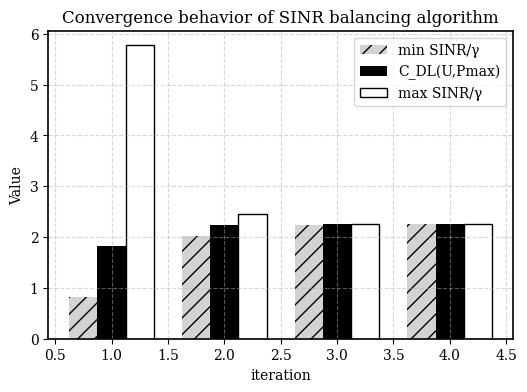

In [190]:
import matplotlib.pyplot as plt

iters = np.arange(1, len(min_list)+1)
bar_width = 0.25

plt.figure(figsize=(6,4))
plt.bar(iters - bar_width, min_list, width=bar_width, label='min SINR/γ', hatch='//', color='lightgray')
plt.bar(iters, mid_list, width=bar_width, label='C_DL(U,Pmax)', color='black')
plt.bar(iters + bar_width, max_list, width=bar_width, label='max SINR/γ', edgecolor='black', fill=False)

plt.xlabel('iteration')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence behavior of SINR balancing algorithm')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [192]:
# --- while 끝난 후: 균형 SINR 검증 --------------------------------

# R_tilde, noise = 1 사용
# Psi, D 등을 이미 만들었으니 u_k^H R_i u_k 재사용 가능.
# SINR_DL = np.zeros(K, dtype=float)
# for i in range(K):
#     ui = U[:, i]
#     num = p_opt[i] * np.real(ui.conj().T @ R_tilde[i] @ ui)
#     den = 1.0 + sum(p_opt[k] * np.real(U[:, k].conj().T @ R_tilde[i] @ U[:, k]) for k in range(K) if k != i)
#     SINR_DL[i] = num / den / gamma[i]

# print("DL SINR per user:", SINR_DL)
# print("Mean DL SINR:", SINR_DL.mean(), "   C* (from eig):", C_n_DL)
# print("SINR spread (max-min):", SINR_DL.max() - SINR_DL.min())

SINR_DL = np.zeros(K, dtype=float)
for i in range(K):
    ui = U[:, i]
    num = p_opt[i] * np.real(ui.conj().T @ R[i] @ ui)
    den = sigma2[i] + sum(p_opt[k] * np.real(U[:, k].conj().T @ R[i] @ U[:, k]) for k in range(K) if k != i)
    SINR_DL[i] = num / den / gamma[i]

print("DL SINR per user:", SINR_DL)
print("Mean DL SINR:", SINR_DL.mean(), "   C* (from eig):", C_n_DL)
print("SINR spread (max-min):", SINR_DL.max() - SINR_DL.min())

DL SINR per user: [2.2493653 2.2493653 2.2493653 2.2493653 2.2493653]
Mean DL SINR: 2.2493653007324843    C* (from eig): 2.249365300732483
SINR spread (max-min): 4.440892098500626e-15


C:\Users\wireless\AppData\Local\Temp\ipykernel_10148\1358638632.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  SINR_DL[i] = num / den / gamma[i]


## Power Minimization Problem

### Data Generation

From "Solution of the Multiuser Downlink Beamforming
Problem With Individual SINR Constraints" - Table 2

In [196]:
import numpy as np

np.random.seed(99)

def steering_vector_ula(theta_rad, M, d, wavelength):
    m = np.arange(M)
    phase = -1j * 2 * np.pi * d / wavelength * m * np.sin(theta_rad)
    a_theta = np.exp(phase) / np.sqrt(M)  # 정규화
    return a_theta  # shape (M,)

def make_user_channel_geometric(M, L, user_center_deg,
                                aoa_spread_deg=1,
                                pathloss_mean_db=-3,
                                pathloss_std_db=3,
                                wavelength=1.0,
                                d=None):
    if d is None:
        d = wavelength / 2  # λ/2 간격
    
    h = np.zeros(M, dtype=np.complex128)

    for _ in range(L):
        # 1) 방위각: 중심각 +/- 산란
        aoa_deg = user_center_deg + np.random.normal(0.0, aoa_spread_deg)
        aoa_rad = np.deg2rad(aoa_deg)

        # 2) 개별 경로 감쇠 (path loss) + 위상
        pl_db = np.random.normal(pathloss_mean_db, pathloss_std_db)
        amp = 10**(pl_db / 20.0)  # dB -> amplitude
        phase = np.random.uniform(0, 2*np.pi)
        alpha = amp * np.exp(1j * phase)

        # 3) 배열 응답
        a_theta = steering_vector_ula(aoa_rad, M, d, wavelength)

        # 4) 경로 누적
        h += alpha * a_theta

    # target_norm2 = M  # 4
    # cur = np.vdot(h, h).real
    # if cur > 0:
    #     h *= np.sqrt(target_norm2 / cur)
        
    return h  # shape (M,)

def sample_user_centers(K, sector_deg=120.0):
    # 균등분포된 방위각 (uniform azimuth pdf)
    return np.random.uniform(-sector_deg/2, sector_deg/2, size=K)

# -----------------------------
# 시뮬레이션 파라미터
# -----------------------------
K = 5      # 사용자 수
M = 4      # BS 안테나 수 (ULA elements)
L = 5

# 경로 수 (multipaths per user)
sector_deg = 120.0

c = 3e8        # [m/s]
f = 3.5e9      # 예: 3.5 GHz  (5G Sub-6 대역)
wavelength = c / f

# wavelength = 1.0
d = wavelength / 2.0

# 사용자 방위각 샘플링
user_centers_deg = sample_user_centers(K, sector_deg=sector_deg)  # shape (K,)

# 채널 행렬 H (K x M)
H = np.zeros((K, M), dtype=np.complex128)

for k in range(K):
    h_k = make_user_channel_geometric(
        M=M,
        L=L,
        user_center_deg=user_centers_deg[k],
        aoa_spread_deg=1,        # azimuth dispersion
        pathloss_mean_db=-3,       # 평균 path 강도
        pathloss_std_db=3,         # 경로별 강도 편차
        wavelength=wavelength,
        d=d
    )

    # 선택적으로 정규화(알고리즘이 안 무너지게 하기 위해 자주 씀):
    # 유저별 채널 파워를 맞춰주면 max-min SINR 알고리즘이 덜 극단적으로 깨집니다.
    # h_k = h_k / np.linalg.norm(h_k) * np.sqrt(M)
    
    H[k, :] = h_k
    
sigma2 = (np.random.normal(loc=1.0, scale=0.4, size=K))**2 * 1e-13
# sigma2 = np.full(K, 1e-13)  # 모든 사용자 동일 노이즈

# sigma2 = np.ones(K)
R = [H[i].reshape(-1,1) @ H[i].conj().reshape(1,-1) for i in range(K)]  # 상관행렬
U = np.zeros((M, K), dtype=np.complex128)
I = np.eye(M, dtype=np.complex128)


In [198]:
import numpy as np
# 1 initialization
n = 0
q_ext = np.ones(K)

Pmax_dbm = 30     # 총 전력 30 dBm
Pmax = 10**((Pmax_dbm - 30)/10.0)  # 1 W
# q_ext = np.ones(K)

C_n_DL = 0.0
R_tilde = [R[i] / sigma2[i] for i in range(K)]
sigma2_virtual = np.ones(K) # 노이즈 파워

# 4 목표 SINR 설정
target_sinr_db = 11   # 10 dB
gamma = np.ones(K) * 10**(target_sinr_db / 20)

# 반복문
max_iter = 10000
while n < max_iter:
    n += 1
    
    for i in range(K):
        Q_i = I.copy()
        for k in range(K):
            if k != i:
                Q_i += q_ext[k] * R_tilde[k]
        A = np.linalg.solve(Q_i, R_tilde[i])
        eigvals, eigvecs = np.linalg.eig(A)
        u_i = eigvecs[:, np.argmax(np.real(eigvals))]

        U[:, i] = u_i / np.linalg.norm(u_i)
    
    Psi = np.zeros((K, K), dtype=np.complex128)
    for k in range(K):
        uk = U[:, k]
        for i in range(K):
            if k != i:
                Psi[i, k] = np.real(uk.conj().T @ R_tilde[i] @ uk)
            else:
                Psi[i, k] = 0
    # D matrix
    D = np.zeros((K, K), dtype=np.complex128)
    for i in range(K):
        ui = U[:, i]
        D[i, i] = gamma[i] / np.real(ui.conj().T @ R_tilde[i] @ ui)
        
    # # --- Break문 : SINR이 Balanced 되었음을 확인 ---
    # SINR_UL_iter = np.zeros(K, dtype=float)
    # for k in range(K):
    #     uk = U[:, k]
    #     num = q_ext[k] * np.real(uk.conj().T @ R_tilde[k] @ uk)
    #     den = 1.0 + sum(q_ext[j] * np.real(uk.conj().T @ R_tilde[j] @ uk)
    #                     for j in range(K) if j != k)
    #     SINR_UL_iter[k] = num / den
    # # ratio(SINR/gamma)
    # SINR_ratio = gamma / SINR_UL_iter   
    # min_ratio = np.min(SINR_ratio)
    # max_ratio = np.max(SINR_ratio)
    
    # print('min, max ratio:', max_ratio - min_ratio)
    
    # print(n, max_ratio - min_ratio)
    # if max_ratio - min_ratio < 1e-2:
    #     break
    
    
    #
    # 8 전력 할당 벡터 q를 지배 고유벡터로 갱신, 지배 고유값 계산
    # 이 때, beamformer U는 고정 (논문 식 15 참고)
    
    # extended uplink coupling matrix
    # Psi Matrix
    sigma_vec = sigma2_virtual.astype(np.complex128).reshape(-1, 1)  # K×1
    # one transpose vector 
    oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
    
    top_left = D @ Psi.T
    top_right = D @ sigma_vec
    bottom_left = (1.0 / Pmax)*(oneT @ D @ Psi.T)
    bottom_right = (1.0/ Pmax)*(oneT @ D @ sigma_vec)
    
    Lambda = np.block([[top_left, top_right],
                    [bottom_left, bottom_right]])
    
    # 전력 할당 벡터 q 갱신
    eigvals, eigvecs = np.linalg.eig(Lambda)
    idx = np.argmax(np.real(eigvals))
    lam_new = float(np.real(eigvals[idx]))
    
    C_n_DL = 1.0 / lam_new
    using_power = np.sum(q_ext)
    
    print('C_n_DL', C_n_DL, 'Total Power:', using_power)
    #
    
    if C_n_DL < 1:
        q_ext = eigvecs[:, idx]  # [ q̃ ; t ]
        
        # q의 마지막 항를 1로 정규화
        t = q_ext[-1]

        q_ext = q_ext / t
        q_ext = q_ext[:K]
            
        C_n_DL = 1.0 / lam_new   
          
    else:
        q_ext = np.real(np.linalg.inv(np.eye(K) - D @ Psi.T) @ D @ np.ones((K, 1)))
        Pmax = np.sum(q_ext)
        
        
# 최종 downlink power allocation 계산
p_opt = np.real(np.linalg.inv(np.eye(K) - D @ Psi) @ D @ np.ones((K, 1)))

C_n_DL 0.29027938099036626 Total Power: 5.0
C_n_DL 1.0470202577128624 Total Power: (0.9999999999999991+0j)
C_n_DL 1.0884420740903298 Total Power: 5.761645643379659e-09
C_n_DL 1.0066472538443645 Total Power: 1.4544916385251331e-09
C_n_DL 1.0000482535186757 Total Power: 1.351134649446748e-09
C_n_DL 1.0000000028770097 Total Power: 1.3504196414000255e-09
C_n_DL 0.999999999999925 Total Power: 1.3504195987834343e-09
C_n_DL 0.9999999999999543 Total Power: (1.3504195987834351e-09-1.1712996596551904e-27j)
C_n_DL 0.9999999999999891 Total Power: (1.3504195987834355e-09-4.0380275433338395e-28j)
C_n_DL 0.9999999999999778 Total Power: (1.3504195987834355e-09-1.5513261818796758e-27j)
C_n_DL 0.9999999999999665 Total Power: (1.3504195987834347e-09-7.76515378681429e-28j)
C_n_DL 0.9999999999999973 Total Power: (1.3504195987834347e-09-7.078132731273591e-28j)
C_n_DL 0.9999999999998843 Total Power: (1.350419598783436e-09-8.282039725192814e-28j)
C_n_DL 0.9999999999999427 Total Power: (1.3504195987834357e-09-

In [199]:
U

array([[ 0.30599405+0.40756197j,  0.18068903-0.26970443j,
         0.63427579+0.j        , -0.08928918-0.27396473j,
         0.60172541+0.j        ],
       [-0.09777196+0.40322586j,  0.64340249+0.j        ,
        -0.14537903+0.38669326j,  0.64687228+0.j        ,
        -0.0829765 +0.36953116j],
       [ 0.29566351-0.39664256j,  0.4257757 +0.45769113j,
         0.37629121+0.10262145j, -0.26541715+0.58936889j,
         0.38865674+0.00958149j],
       [ 0.56865473+0.j        , -0.0745555 +0.29037836j,
        -0.3225333 +0.4133685j , -0.21207513-0.18907459j,
        -0.22461641+0.5411929j ]])

## Visualization

From "Solution of the Multiuser Downlink Beamforming
Problem With Individual SINR Constraints" - Figure 1

In [200]:
# From previous run

U_fixed = np.array([[ 0.30599405+0.40756197j,  0.18068903-0.26970443j,
         0.63427579+0.j        , -0.08928918-0.27396473j,
         0.60172541+0.j        ],
       [-0.09777196+0.40322586j,  0.64340249+0.j        ,
        -0.14537903+0.38669326j,  0.64687228+0.j        ,
        -0.0829765 +0.36953116j],
       [ 0.29566351-0.39664256j,  0.4257757 +0.45769113j,
         0.37629121+0.10262145j, -0.26541715+0.58936889j,
         0.38865674+0.00958149j],
       [ 0.56865473+0.j        , -0.0745555 +0.29037836j,
        -0.3225333 +0.4133685j , -0.21207513-0.18907459j,
        -0.22461641+0.5411929j ]])

In [225]:
Pmax_dbm = np.arange(0, 0.1, 0.01)
Pmax = 10**((Pmax_dbm - 30)/10.0)

In [226]:
Pmax

array([0.001     , 0.00100231, 0.00100462, 0.00100693, 0.00100925,
       0.00101158, 0.00101391, 0.00101625, 0.00101859, 0.00102094])

In [221]:
Pmax_dbm = np.arange(0,1e-10,1e-11)
Pmax = 10**((Pmax_dbm - 30)/10.0)  # 1 W

In [222]:
Pmax_dbm

array([0.e+00, 1.e-11, 2.e-11, 3.e-11, 4.e-11, 5.e-11, 6.e-11, 7.e-11,
       8.e-11, 9.e-11, 1.e-10])

In [224]:
Pmax

array([0.001     , 0.00102329, 0.00104713, 0.00107152, 0.00109648,
       0.00112202, 0.00114815, 0.0011749 , 0.00120226, 0.00123027])

In [227]:
Pmax_dbm = np.arange(0,1,0.1)
Pmax = 10**((Pmax_dbm - 30)/10.0)  # 1 W

C_n_DL_list = []

for pmax in Pmax:
    q_ext = np.zeros(K)

    Psi = np.zeros((K, K), dtype=np.complex128)
    for k in range(K):
        uk = U_fixed[:, k]
        for i in range(K):
            if k != i:
                Psi[i, k] = np.real(uk.conj().T @ R_tilde[i] @ uk)
            else:
                Psi[i, k] = 0
                
    D = np.zeros((K, K), dtype=np.complex128)
    for i in range(K):
        ui = U_fixed[:, i]
        D[i, i] = gamma[i] / np.real(ui.conj().T @ R_tilde[i] @ ui)
        
    sigma_vec = sigma2_virtual.astype(np.complex128).reshape(-1, 1)  # K×1

    oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
        
    top_left = D @ Psi.T
    top_right = D @ sigma_vec
    bottom_left = (1.0 / pmax)*(oneT @ D @ Psi.T)
    bottom_right = (1.0/ pmax)*(oneT @ D @ sigma_vec)
        
    Lambda = np.block([[top_left, top_right],
                    [bottom_left, bottom_right]])
        
    eigvals, eigvecs = np.linalg.eig(Lambda)
    idx = np.argmax(np.real(eigvals))
    lam_new = float(np.real(eigvals[idx]))

    C_n_DL = 1.0 / lam_new
        
    q_ext = eigvecs[:, idx]  # [ q̃ ; t ]
            
    # q의 마지막 항를 1로 정규화
    t = q_ext[-1]
    q_ext = q_ext / t
    q_ext = q_ext[:K]
    # print(q_ext)
    print('C_n_DL', C_n_DL)
    C_n_DL_list.append(C_n_DL)

C_n_DL 1.1075531553668454
C_n_DL 1.1075531592877021
C_n_DL 1.1075531631193105
C_n_DL 1.1075531668637009
C_n_DL 1.107553170522857
C_n_DL 1.1075531740987232
C_n_DL 1.10755317759319
C_n_DL 1.1075531810081143
C_n_DL 1.1075531843453048
C_n_DL 1.1075531876065308


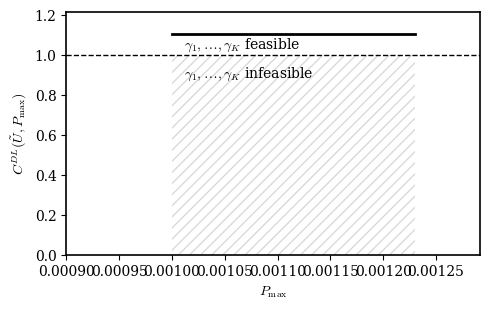

In [212]:
# figure / axis 생성
fig, ax = plt.subplots(figsize=(5,3.2))

# 글꼴과 스타일: 논문 흑백풍
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",     # Computer Modern 수식 느낌
    "axes.linewidth": 1.2,
})

# 1) infeasible 영역 (y < 1) 빗금
y_min = 0
y_thresh = 1.0
ax.fill_between(
    Pmax,
    y_min,
    y_thresh,
    facecolor='white',
    edgecolor='black',
    hatch='///',
    linewidth=0.0,
    alpha=0.15
)

# 2) C_DL 곡선 (실선, 굵게)
ax.plot(
    Pmax,
    C_n_DL_list,
    color='black',
    linewidth=2.0,
)

# 3) y = 1 경계선 (얇은 수평선)
ax.axhline(
    y=y_thresh,
    color='black',
    linestyle='--',
    linewidth=1.0
)

# 4) "feasible" / "infeasible" 라벨 흉내
#   - 논문 그림은 y=1 위쪽에 'γ1,...,γK feasible'
#     아래쪽 해칭 영역에는 'γ1,...,γK infeasible'
#   - 우리는 단순화해서 feasible / infeasible만 적어줄게
x_text = Pmax[0] + 0.05*(Pmax[-1] - Pmax[0])

ax.text(
    x_text,
    y_thresh + 0.05*(max(C_n_DL_list)-y_thresh),
    r'$\gamma_1,\ldots,\gamma_K$ feasible',
    fontsize=10,
    va='bottom'
)

ax.text(
    x_text,
    y_thresh - 0.05*(y_thresh - y_min),
    r'$\gamma_1,\ldots,\gamma_K$ infeasible',
    fontsize=10,
    va='top'
)

# 5) 축 라벨 (수식 그대로)
ax.set_xlabel(r'$P_{\max}$')
ax.set_ylabel(r'$C^{DL}(\tilde{U}, P_{\max})$')

# 6) 축 범위 / 틱
ax.set_xlim(Pmax[0] * 0.9, Pmax[-1] * 1.05)
ax.set_ylim(y_min, max(C_n_DL_list) * 1.1)

# 7) grid, legend 없음
ax.grid(False)
ax.legend([], [], frameon=False)

# 8) 여백 정리
plt.tight_layout()
plt.show()

From "Solution of the Multiuser Downlink Beamforming
Problem With Individual SINR Constraints" - Figure 2

In [114]:
K = 5 # 유저 수
M = 4 # BS 안테나 수

Pmax = 10
    
# 생성 채널 단순화
H = (np.random.randn(K, M) + 1j * np.random.randn(K, M)) / np.sqrt(2) # Rayleigh 채널

sigma2 = (np.random.normal(loc=1.0, scale=0.4, size=K)) ** 2  # 잡음 전력
# sigma2 = np.ones(K) 
R = [H[i].reshape(-1,1) @ H[i].conj().reshape(1,-1) for i in range(K)]  # 상관행렬
U = np.zeros((M, K), dtype=np.complex128)
I = np.eye(M, dtype=np.complex128)

import numpy as np
# 1 initialization
n = 0
q_ext = np.zeros(K)
 
lam_new = 0.0
epsilon = 1e-6 # 수렴 조건

# 2 채널 행렬을 잡음 전력으로 정규화 : downlink
R_tilde = [R[i] / sigma2[i] for i in range(K)]

# 3 잡음 전력을 1로 정규화 : virtual uplink의 정의에 따라
sigma2_virtual = np.ones(K) # 노이즈 파워
 
# 4 목표 SINR 설정
target_sinr_db = 1   # 10 dB
gamma = np.ones(K) * 10**(target_sinr_db / 10)

# 반복문
max_iter = 100
while n < max_iter:
    
    # 5 반복 카운터 증가
    n += 1
    
    # 6 사용자 별 수신기 벡터 ui를 고유벡터로 업데이트 : Beamforming Step
    
    # 최대 고유값에 대응하는 고유벡터를 반환해서 수신 beamforming 벡터로 사용 (uplink이기 때문)
    # 이 떄 q는 고정 (논문 식 30,31 참고)
    for i in range(K):   
        # Q_i 계산
        Q_i = I.copy()
        for k in range(K):
            if k != i:
                Q_i += q_ext[k] * R_tilde[k]

        # Generalized Eigenvalue 문제 풀이
        A = np.linalg.solve(Q_i, R_tilde[i])
        eigvals, eigvecs = np.linalg.eig(A)
        u_i = eigvecs[:, np.argmax(np.real(eigvals))]
        
        # 7 수신 벡터 ui 정규화
        U[:, i] = u_i / np.linalg.norm(u_i)
    
    # --- 성능 시각화 ---
    SINR_UL_iter = np.zeros(K, dtype=float)
    for k in range(K):
        uk = U[:, k]
        num = q_ext[k] * np.real(uk.conj().T @ R_tilde[k] @ uk)
        den = 1.0 + sum(q_ext[j] * np.real(uk.conj().T @ R_tilde[j] @ uk)
                        for j in range(K) if j != k)
        SINR_UL_iter[k] = num / den
    # ratio(SINR/gamma)
    SINR_ratio = SINR_UL_iter / gamma    
    min_ratio = np.min(SINR_ratio)
    max_ratio = np.max(SINR_ratio)
    
    # 8 전력 할당 벡터 q를 지배 고유벡터로 갱신, 지배 고유값 계산
    # 이 때, beamformer U는 고정 (논문 식 15 참고)
    
    # extended uplink coupling matrix
    # Psi Matrix
    Psi = np.zeros((K, K), dtype=np.complex128)
    for k in range(K):
        for i in range(K):
            if k != i:
                Psi[i, k] = np.real(U[:, k].conj().T @ R_tilde[i] @ U[:, k])
            else:
                Psi[i, k] = 0
    # D matrix
    D = np.zeros((K, K), dtype=np.complex128)
    for i in range(K):
        D[i, i] = gamma[i] / np.real(U[:, i].conj().T @ R_tilde[i] @ U[:, i])
    # Sigma matrix
    sigma_vec = sigma2_virtual.astype(np.complex128).reshape(-1, 1)  # K×1
    # one transpose vector 
    oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
    
    top_left = D @ Psi.T
    top_right = D @ sigma_vec
    bottom_left = (1.0 / Pmax)*(oneT @ D @ Psi.T)
    bottom_right = (1.0/ Pmax)*(oneT @ D @ sigma_vec)
    
    Lambda = np.block([[top_left, top_right],
                       [bottom_left, bottom_right]])
    
    # 전력 할당 벡터 q 갱신
    eigvals, eigvecs = np.linalg.eig(Lambda)
    idx = np.argmax(np.real(eigvals))
    lam_old, lam_new = lam_new, float(np.real(eigvals[idx]))
    q_ext = eigvecs[:, idx]  # [ q̃ ; t ]
    
    # q의 마지막 항를 1로 정규화
    t = q_ext[-1]
    q_ext = q_ext / t
    q_ext = q_ext[:K]
    
    # if np.isclose(t, 0.0):
    #     q_ext = q_ext / (np.sum(np.abs(q_ext)) + 1e-12)
    #     q_ext = q_ext[:K]
    # else:
    #     q_ext = q_ext / t
    #     q_ext = q_ext[:K]
    
    # 9 현재 iteration에서의 균형 SINR
    C_n_DL = 1.0 / lam_new
    
    print(C_n_DL)
    
    # 저장 (리스트로)
    if n == 1:
        min_list, mid_list, max_list = [], [], []
    
    if n > 1:
        min_list.append(min_ratio)
        mid_list.append(C_n_DL)
        max_list.append(max_ratio)
    
    # 10 수렴 조건 체크
    if np.abs(lam_new - lam_old) < epsilon:
        break

# 11 최종 고유벡터를 구해 최적 전력 할당 벡터 P 계산

# extended Downlink coupling matrix
# Psi Matrix
Psi = np.zeros((K, K), dtype=np.complex128)
for k in range(K):
    uk = U[:, k]
    for i in range(K):
        if k != i:
            Psi[i, k] = np.real(uk.conj().T @ R[i] @ uk)
        else:
            Psi[i, k] = 0
# D matrix
D = np.zeros((K, K), dtype=np.complex128)
for i in range(K):
    ui = U[:, i]
    D[i, i] = gamma[i] / np.real(ui.conj().T @ R[i] @ ui)
# Sigma matrix
sigma_vec = sigma2.astype(np.complex128).reshape(-1, 1)  # K×1
# one transpose vector 
oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
    
top_left = D @ Psi
top_right = D @ sigma_vec
bottom_left = (1.0 / Pmax)*(oneT @ D @ Psi)
bottom_right = (1.0/ Pmax)*(oneT @ D @ sigma_vec)
    
Upsilon = np.block([[top_left, top_right],
                   [bottom_left, bottom_right]])
    
# 전력 할당 벡터 p 갱신
eigvals, eigvecs = np.linalg.eig(Upsilon)
idx = np.argmax(np.real(eigvals))
lam_max = float(np.real(eigvals[idx]))
p_opt = eigvecs[:, idx]  # [ p; t ]
    
# q의 마지막 항를 1로 정규화
t = p_opt[-1]
if np.isclose(t, 0.0):
    p_opt = p_opt / (np.sum(np.abs(p_opt)) + 1e-12)
    p_opt = p_opt[:K]
else:
    p_opt = p_opt / t
    p_opt = p_opt[:K]
    
print(lam_max, 1/lam_max)
print(p_opt)

0.5488319991364928
0.9395664056323277
0.946343398095696
0.9463445805289732
0.946344580529104
1.0566975503160771 0.9463445805291042
[2.36173255-1.22273642e-17j 2.31478634-1.86184753e-17j
 2.80203289+7.32560175e-18j 1.29486177+1.21522056e-17j
 1.22658646+6.09802849e-18j]


C:\Users\wireless\AppData\Local\Temp\ipykernel_17304\1284048244.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  SINR_UL_iter[k] = num / den


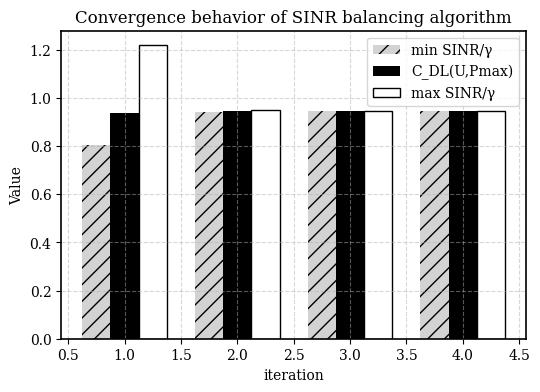

In [115]:
import matplotlib.pyplot as plt

iters = np.arange(1, len(min_list)+1)
bar_width = 0.25

plt.figure(figsize=(6,4))
plt.bar(iters - bar_width, min_list, width=bar_width, label='min SINR/γ', hatch='//', color='lightgray')
plt.bar(iters, mid_list, width=bar_width, label='C_DL(U,Pmax)', color='black')
plt.bar(iters + bar_width, max_list, width=bar_width, label='max SINR/γ', edgecolor='black', fill=False)

plt.xlabel('iteration')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence behavior of SINR balancing algorithm')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

From "Solution of the Multiuser Downlink Beamforming
Problem With Individual SINR Constraints" - Figure 3

In [110]:
K = 5 # 유저 수
M = 4 # BS 안테나 수

Pmax = 50
    
# 생성 채널 단순화
H = (np.random.randn(K, M) + 1j * np.random.randn(K, M)) / np.sqrt(2) # Rayleigh 채널

sigma2 = (np.random.normal(loc=1.0, scale=0.4, size=K)) ** 2  # 잡음 전력
# sigma2 = np.ones(K) 
R = [H[i].reshape(-1,1) @ H[i].conj().reshape(1,-1) for i in range(K)]  # 상관행렬
U = np.zeros((M, K), dtype=np.complex128)
I = np.eye(M, dtype=np.complex128)

import numpy as np

n = 0
q_ext = np.zeros(K)

C_n_DL = 0.0
R_tilde = [R[i] / sigma2[i] for i in range(K)]
sigma2_virtual = np.ones(K) # 노이즈 파워

target_sinr_db = 4   # 10 dB
gamma = np.ones(K) * 10**(target_sinr_db / 10)

# 반복문
max_iter = 100

sum_power_list = []
C_UL_list = []
U_list = []
q_list = []
while n < max_iter:
    n += 1
    
    for i in range(K):
        Q_i = I.copy()
        for k in range(K):
            if k != i:
                Q_i += q_ext[k] * R_tilde[k]
        A = np.linalg.solve(Q_i, R_tilde[i])
        eigvals, eigvecs = np.linalg.eig(A)
        u_i = eigvecs[:, np.argmax(np.real(eigvals))]

        U[:, i] = u_i / np.linalg.norm(u_i)
    U_list.append(np.array(U, copy=True))
    
    Psi = np.zeros((K, K), dtype=np.complex128)
    for k in range(K):
        uk = U[:, k]
        for i in range(K):
            if k != i:
                Psi[i, k] = np.real(uk.conj().T @ R_tilde[i] @ uk)
            else:
                Psi[i, k] = 0
    # D matrix
    D = np.zeros((K, K), dtype=np.complex128)
    for i in range(K):
        ui = U[:, i]
        D[i, i] = gamma[i] / np.real(ui.conj().T @ R_tilde[i] @ ui)
        
    # # --- Break문 : SINR이 Balanced 되었음을 확인 ---
    # SINR_UL_iter = np.zeros(K, dtype=float)
    # for k in range(K):
    #     uk = U[:, k]
    #     num = q_ext[k] * np.real(uk.conj().T @ R_tilde[k] @ uk)
    #     den = 1.0 + sum(q_ext[j] * np.real(uk.conj().T @ R_tilde[j] @ uk)
    #                     for j in range(K) if j != k)
    #     SINR_UL_iter[k] = num / den
    # # ratio(SINR/gamma)
    # SINR_ratio = gamma / SINR_UL_iter   
    # min_ratio = np.min(SINR_ratio)
    # max_ratio = np.max(SINR_ratio)
    
    # print('min, max ratio:', max_ratio - min_ratio)
    
    # print(n, max_ratio - min_ratio)
    # if max_ratio - min_ratio < 1e-2:
    #     break
    
    
    #
    # 8 전력 할당 벡터 q를 지배 고유벡터로 갱신, 지배 고유값 계산
    # 이 때, beamformer U는 고정 (논문 식 15 참고)
    
    # extended uplink coupling matrix
    # Psi Matrix
    sigma_vec = sigma2_virtual.astype(np.complex128).reshape(-1, 1)  # K×1
    # one transpose vector 
    oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
    
    top_left = D @ Psi.T
    top_right = D @ sigma_vec
    bottom_left = (1.0 / Pmax)*(oneT @ D @ Psi.T)
    bottom_right = (1.0/ Pmax)*(oneT @ D @ sigma_vec)
    
    Lambda = np.block([[top_left, top_right],
                    [bottom_left, bottom_right]])
    
    # 전력 할당 벡터 q 갱신
    eigvals, eigvecs = np.linalg.eig(Lambda)
    idx = np.argmax(np.real(eigvals))
    lam_new = float(np.real(eigvals[idx]))
    
    C_n_DL = 1.0 / lam_new
    using_power = np.sum(q_ext)
    
    print('C_n_DL', C_n_DL, 'Total Power:', using_power)
    #
    
    if C_n_DL < 1:
        q_ext = eigvecs[:, idx]  # [ q̃ ; t ]
        
        # q의 마지막 항를 1로 정규화
        t = q_ext[-1]

        q_ext = q_ext / t
        q_ext = q_ext[:K]
            
        C_n_DL = 1.0 / lam_new   
          
    else:
        q_ext = np.real(np.linalg.inv(np.eye(K) - D @ Psi.T) @ D @ np.ones((K, 1)))
        Pmax = np.sum(q_ext)
    
    q_list.append(q_ext)
    
    C_UL_list.append(C_n_DL)
    sum_power_list.append(Pmax)
        
# 최종 downlink power allocation 계산
p_opt = np.real(np.linalg.inv(np.eye(K) - D @ Psi) @ D @ np.ones((K, 1)))

C_n_DL 0.4205228340720077 Total Power: 0.0
C_n_DL 0.983661936747019 Total Power: (50.00000000000002+0j)
C_n_DL 1.2237235005208464 Total Power: (50.00000000000002+0j)
C_n_DL 1.0231729975886685 Total Power: 22.604043731678516
C_n_DL 1.0003339539197966 Total Power: 20.821679056179732
C_n_DL 1.000000062694348 Total Power: 20.796869394645658
C_n_DL 1.0000000000000036 Total Power: 20.796864739343977
C_n_DL 0.9999999999999998 Total Power: 20.796864739343793
C_n_DL 1.0 Total Power: (20.79686473934376+9.029549503023136e-17j)
C_n_DL 1.0000000000000002 Total Power: 20.796864739343793
C_n_DL 0.9999999999999998 Total Power: 20.796864739343796
C_n_DL 1.0000000000000004 Total Power: (20.796864739343796+1.273515162578824e-16j)
C_n_DL 1.0000000000000004 Total Power: 20.7968647393438
C_n_DL 1.0000000000000004 Total Power: 20.796864739343807
C_n_DL 1.0000000000000002 Total Power: 20.796864739343807
C_n_DL 1.0000000000000004 Total Power: 20.796864739343782
C_n_DL 1.0000000000000002 Total Power: 20.7968647

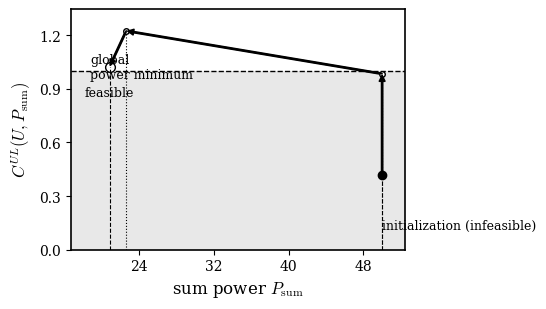

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# # ====== 예시 데이터 (여기를 네 실제 로그로 바꿔) ======
# sum_power_list = np.array([50, 45, 37, 28, 24, 22], dtype=float)
# C_UL_list      = np.array([0.40, 0.70, 0.95, 1.02, 1.08, 1.11], dtype=float)

sum_power_list_view = sum_power_list[:4]
C_UL_list_view      = C_UL_list[:4]

feasible_iter = 3  # 이 인덱스 이후는 feasible 이라고 표시하고 싶다 (C>=1 최초 진입)

# ====== 기본 figure/axis 설정 (흑백 논문 느낌) ======
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
})

fig, ax = plt.subplots(figsize=(5.5,3.2))

# ====== 회색 영역 (infeasible zone, y<1) ======
y_thresh = 1.0
ax.fill_between(
    [min(sum_power_list_view)*0.8, max(sum_power_list_view)*1.05],
    0, y_thresh,
    facecolor='lightgray',
    alpha=0.5
)

# ====== y=1 수평선 ======
ax.axhline(
    y=y_thresh,
    color='black',
    linestyle='--',
    linewidth=1.0
)

# ====== iterative path (화살표로 progression) ======
# 경로 전체를 선으로 먼저 그린다
ax.plot(
    sum_power_list_view,
    C_UL_list_view,
    color='black',
    linewidth=2.0
)

# 각 이웃한 점들 사이에 화살표(진행 방향)를 추가
for i in range(len(sum_power_list_view)-1):
    x0, y0 = sum_power_list_view[i],   C_UL_list_view[i]
    x1, y1 = sum_power_list_view[i+1], C_UL_list_view[i+1]
    ax.annotate(
        '', xy=(x1,y1), xytext=(x0,y0),
        arrowprops=dict(
            arrowstyle='-|>',
            linewidth=1.2,
            color='black',
            shrinkA=0, shrinkB=0
        )
    )

# ====== 점(marker) 찍기 (특히 초기/feasible 진입 강조) ======
for i, (x, y) in enumerate(zip(sum_power_list_view, C_UL_list_view)):
    if i == 0:
        # 초기화 지점 (infeasible)
        ax.plot(x, y, marker='o', markersize=6,
                markerfacecolor='black', markeredgecolor='black')
    elif i == feasible_iter:
        # 처음 feasible로 진입한 지점 강조
        ax.plot(x, y, marker='o', markersize=7,
                markerfacecolor='white', markeredgecolor='black', linewidth=1.2)
        ax.text(x, y - 0.08*(ax.get_ylim()[1]-ax.get_ylim()[0]),
                "feasible", fontsize=9,
                ha='center', va='top')
    else:
        ax.plot(x, y, marker='o', markersize=4,
                markerfacecolor='white', markeredgecolor='black')

# ====== 세로 점선들 (P_sum^(n) 들)
# 논문 그림에서는 P_max, P_sum^(3), P_sum^(4), ... 처럼 수직선 그어서
# "우리가 전력합을 줄여나가고 있다"를 강조해.
for i, x in enumerate(sum_power_list_view):
    ls = ':' if i not in [0, feasible_iter] else '--'  # 첫 점이나 feasible 점은 좀 더 강조하고 싶으면 바꿔도 됨
    ax.axvline(
        x=x,
        ymin=0,
        ymax=(C_UL_list_view[i] / (ax.get_ylim()[1]*1.05)),
        color='black',
        linestyle=ls,
        linewidth=0.8
    )

# ====== 라벨들 (축 라벨/타이틀) ======
ax.set_xlabel(r'sum power $P_{\mathrm{sum}}$', fontsize=12)
ax.set_ylabel(r'$C^{UL}(U, P_{\mathrm{sum}})$', fontsize=12)

# y=1 부근에 "initialization (infeasible)" 라벨 비슷하게 넣어주기
ax.text(
    sum_power_list_view[0],
    0.1 * y_thresh,
    "initialization (infeasible)",
    fontsize=9,
    ha='left', va='bottom'
)

# global power minimum 라벨 흉내:
ax.text(
    min(sum_power_list_view)*0.9,
    max(C_UL_list_view)*0.9,
    "global\npower minimum",
    fontsize=9,
    ha='left', va='top'
)

# ====== 축 방향/범위/스타일 ======
ax.set_xlim(min(sum_power_list_view)*0.8, max(sum_power_list_view)*1.05)
ax.set_ylim(0, max(C_UL_list_view)*1.1)

ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=False))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# 격자 없이, 범례 없이
ax.grid(False)

plt.tight_layout()
plt.show()


In [112]:
Pmax = np.arange(1,50,1)

C_n_DL_Curve = []
for U_fixed in U_list[:10]:
    
    C_n_DL_list = []
    for pmax in Pmax:
        q_ext = np.zeros(K)

        Psi = np.zeros((K, K), dtype=np.complex128)
        for k in range(K):
            uk = U_fixed[:, k]
            for i in range(K):
                if k != i:
                    Psi[i, k] = np.real(uk.conj().T @ R_tilde[i] @ uk)
                else:
                    Psi[i, k] = 0
                    
        D = np.zeros((K, K), dtype=np.complex128)
        for i in range(K):
            ui = U_fixed[:, i]
            D[i, i] = gamma[i] / np.real(ui.conj().T @ R_tilde[i] @ ui)
            
        sigma_vec = sigma2_virtual.astype(np.complex128).reshape(-1, 1)  # K×1

        oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
            
        top_left = D @ Psi.T
        top_right = D @ sigma_vec
        bottom_left = (1.0 / pmax)*(oneT @ D @ Psi.T)
        bottom_right = (1.0/ pmax)*(oneT @ D @ sigma_vec)
            
        Lambda = np.block([[top_left, top_right],
                        [bottom_left, bottom_right]])
            
        eigvals, eigvecs = np.linalg.eig(Lambda)
        idx = np.argmax(np.real(eigvals))
        lam_new = float(np.real(eigvals[idx]))

        C_n_DL = 1.0 / lam_new
            
        q_ext = eigvecs[:, idx]  # [ q̃ ; t ]
                
        # q의 마지막 항를 1로 정규화
        t = q_ext[-1]
        q_ext = q_ext / t
        q_ext = q_ext[:K]

        print('C_n_DL', C_n_DL)
        C_n_DL_list.append(C_n_DL)
    C_n_DL_Curve.append(C_n_DL_list)

C_n_DL 0.20730625275218464
C_n_DL 0.2784445938182301
C_n_DL 0.31497487147095676
C_n_DL 0.33726969583494315
C_n_DL 0.3523061902363307
C_n_DL 0.36313666790728116
C_n_DL 0.37131085838601574
C_n_DL 0.377699891094572
C_n_DL 0.38283130151221645
C_n_DL 0.38704331031775124
C_n_DL 0.39056278916058756
C_n_DL 0.39354761446760333
C_n_DL 0.396111050016824
C_n_DL 0.3983364693914903
C_n_DL 0.4002866078894001
C_n_DL 0.4020095775944965
C_n_DL 0.4035428942235779
C_n_DL 0.40491624255894326
C_n_DL 0.40615341865587873
C_n_DL 0.40727372125252254
C_n_DL 0.4082929664153837
C_n_DL 0.40922423931696555
C_n_DL 0.4100784593171916
C_n_DL 0.41086481029508837
C_n_DL 0.4115910722888834
C_n_DL 0.4122638798804506
C_n_DL 0.41288892553343415
C_n_DL 0.4134711210984017
C_n_DL 0.414014727193538
C_n_DL 0.41452345767686016
C_n_DL 0.41500056463092033
C_n_DL 0.41544890797329015
C_n_DL 0.4158710128428216
C_n_DL 0.4162691171950563
C_n_DL 0.41664521150183387
C_n_DL 0.41700107204222475
C_n_DL 0.41733828896017877
C_n_DL 0.41765829002

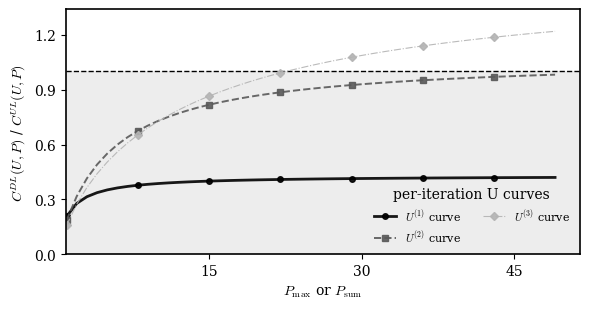

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 준비물
Pmax_array = np.arange(1, 50)  # x축 for 곡선
num_curves_to_show = 3         # U^(1)~U^(4)만 본다고 하자
iter_view = 0 # 동일하게 잘라서 비교
sum_power_list_view = np.array(sum_power_list[:iter_view], dtype=float)
C_UL_list_view      = np.array(C_UL_list[:iter_view], dtype=float)

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
})

fig, ax = plt.subplots(figsize=(6,3.2))

# 1) feasible 경계 영역 (C<1 음영)
y_thresh = 1.0
ax.fill_between(
    [min(Pmax_array)*0.9, max(Pmax_array)*1.05],
    0, y_thresh,
    facecolor='lightgray',
    alpha=0.4
)

# 2) y=1 수평선
ax.axhline(
    y=y_thresh,
    color='black',
    linestyle='--',
    linewidth=1.0
)

# 3) iteration별 C^{DL}(U^(n), Pmax) 곡선 (코드 A 스타일)
line_styles = ['-', '--', '-.', ':']
markers     = ['o', 's', 'D', '^', 'v', 'x', '+', '*']

for idx in range(num_curves_to_show):
    curve = np.array(C_n_DL_Curve[idx], dtype=float)

    ls = line_styles[idx % len(line_styles)]
    mk = markers[idx % len(markers)]

    lw = 2.0 - 1.2 * (idx / max(1, num_curves_to_show-1))
    gray_level = 0.0 + 0.7 * (idx / max(1, num_curves_to_show-1))
    color_val = str(gray_level)

    label_txt = rf'$U^{{({idx+1})}}$ curve'

    ax.plot(
        Pmax_array,
        curve,
        linestyle=ls,
        marker=mk,
        markevery=7,
        markersize=4,
        linewidth=lw,
        color=color_val,
        alpha=0.9,
        label=label_txt
    )

# 4) 실제 알고리즘 경로 (코드 B 스타일의 점/화살표)
ax.plot(
    sum_power_list_view,
    C_UL_list_view,
    color='black',
    linewidth=2.0,
    alpha=1.0,
)

for i in range(len(sum_power_list_view)-1):
    x0, y0 = sum_power_list_view[i],   C_UL_list_view[i]
    x1, y1 = sum_power_list_view[i+1], C_UL_list_view[i+1]

    ax.annotate(
        '', xy=(x1,y1), xytext=(x0,y0),
        arrowprops=dict(
            arrowstyle='-|>',
            linewidth=1.2,
            color='black',
            shrinkA=0, shrinkB=0
        )
    )

# 각 점 찍기
for i, (x,y) in enumerate(zip(sum_power_list_view, C_UL_list_view)):
    ax.plot(
        x, y,
        marker='o',
        markersize=6 if i==0 else 4,
        markerfacecolor=('white' if i>0 else 'black'),
        markeredgecolor='black',
        linewidth=1.2
    )
    ax.text(x, y,
            f'{i+1}', fontsize=8,
            ha='left', va='bottom')

# 5) 축 라벨/범위/legend 등
ax.set_xlabel(r'$P_{\max}$ or $P_{\mathrm{sum}}$')
ax.set_ylabel(r'$C^{DL}(U, P)$ / $C^{UL}(U,P)$')

# 범위 깔끔하게
all_y_vals = np.concatenate([
    np.concatenate(C_n_DL_Curve[:num_curves_to_show]),
    C_UL_list_view
]).astype(float)
ax.set_ylim(0, max(all_y_vals)*1.1)

all_x_vals = np.concatenate([
    Pmax_array,
    sum_power_list_view
]).astype(float)
ax.set_xlim(min(all_x_vals)*0.9, max(all_x_vals)*1.05)

ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax.legend(frameon=False, fontsize=8, ncol=2, title='per-iteration U curves')
ax.grid(False)

plt.tight_layout()
plt.show()


From "Solution of the Multiuser Downlink Beamforming
Problem With Individual SINR Constraints" - Figure 4

In [145]:
import numpy as np
np.random.seed(45)  

K = 5 # 유저 수
M = 4 # BS 안테나 수

# env

    
# 생성 채널 단순화
H = (np.random.randn(K, M) + 1j * np.random.randn(K, M)) / np.sqrt(2) # Rayleigh 채널
sigma2 = (np.random.normal(loc=1.0, scale=0.4, size=K)) ** 2  # 잡음 전력
# sigma2 = np.ones(K) 
R = [H[i].reshape(-1,1) @ H[i].conj().reshape(1,-1) for i in range(K)]  # 상관행렬
U = np.zeros((M, K), dtype=np.complex128)
I = np.eye(M, dtype=np.complex128)


target_sinr_db_list = np.linspace(0, 5, 20)
gamma_list = [np.ones(K) * 10**(db / 10) for db in target_sinr_db_list]

p_opt_sum_list = []
for gamma in gamma_list:
    Pmax = 50
    
    n = 0
    q_ext = np.zeros(K)

    C_n_DL = 0.0
    R_tilde = [R[i] / sigma2[i] for i in range(K)]
    sigma2_virtual = np.ones(K) # 노이즈 파워
    
    # 반복문
    max_iter = 100
    while n < max_iter:
        n += 1
        
        for i in range(K):
            Q_i = I.copy()
            for k in range(K):
                if k != i:
                    Q_i += q_ext[k] * R_tilde[k]
            A = np.linalg.solve(Q_i, R_tilde[i])
            eigvals, eigvecs = np.linalg.eig(A)
            u_i = eigvecs[:, np.argmax(np.real(eigvals))]

            U[:, i] = u_i / np.linalg.norm(u_i)
        
        Psi = np.zeros((K, K), dtype=np.complex128)
        for k in range(K):
            uk = U[:, k]
            for i in range(K):
                if k != i:
                    Psi[i, k] = np.real(uk.conj().T @ R_tilde[i] @ uk)
                else:
                    Psi[i, k] = 0
        # D matrix
        D = np.zeros((K, K), dtype=np.complex128)
        for i in range(K):
            ui = U[:, i]
            D[i, i] = gamma[i] / np.real(ui.conj().T @ R_tilde[i] @ ui)
            
        # # --- Break문 : SINR이 Balanced 되었음을 확인 ---
        # SINR_UL_iter = np.zeros(K, dtype=float)
        # for k in range(K):
        #     uk = U[:, k]
        #     num = q_ext[k] * np.real(uk.conj().T @ R_tilde[k] @ uk)
        #     den = 1.0 + sum(q_ext[j] * np.real(uk.conj().T @ R_tilde[j] @ uk)
        #                     for j in range(K) if j != k)
        #     SINR_UL_iter[k] = num / den
        # # ratio(SINR/gamma)
        # SINR_ratio = gamma / SINR_UL_iter   
        # min_ratio = np.min(SINR_ratio)
        # max_ratio = np.max(SINR_ratio)
        
        # print('min, max ratio:', max_ratio - min_ratio)
        
        # print(n, max_ratio - min_ratio)
        # if max_ratio - min_ratio < 1e-2:
        #     break
        
        
        #
        # 8 전력 할당 벡터 q를 지배 고유벡터로 갱신, 지배 고유값 계산
        # 이 때, beamformer U는 고정 (논문 식 15 참고)
        
        # extended uplink coupling matrix
        # Psi Matrix
        sigma_vec = sigma2_virtual.astype(np.complex128).reshape(-1, 1)  # K×1
        # one transpose vector 
        oneT = np.ones((1, K), dtype=np.complex128)  # 1×K
        
        top_left = D @ Psi.T
        top_right = D @ sigma_vec
        bottom_left = (1.0 / Pmax)*(oneT @ D @ Psi.T)
        bottom_right = (1.0/ Pmax)*(oneT @ D @ sigma_vec)
        
        Lambda = np.block([[top_left, top_right],
                        [bottom_left, bottom_right]])
        
        # 전력 할당 벡터 q 갱신
        eigvals, eigvecs = np.linalg.eig(Lambda)
        idx = np.argmax(np.real(eigvals))
        lam_new = float(np.real(eigvals[idx]))
        
        C_n_DL = 1.0 / lam_new
        using_power = np.sum(q_ext)
        
        print('C_n_DL', C_n_DL, 'Total Power:', using_power)
        #
        
        if C_n_DL < 1:
            q_ext = eigvecs[:, idx]  # [ q̃ ; t ]
            
            # q의 마지막 항를 1로 정규화
            t = q_ext[-1]

            q_ext = q_ext / t
            q_ext = q_ext[:K]
                
            C_n_DL = 1.0 / lam_new   
            
        else:
            q_ext = np.real(np.linalg.inv(np.eye(K) - D @ Psi.T) @ D @ np.ones((K, 1)))
            Pmax = np.sum(q_ext)
            
            
    # 최종 downlink power allocation 계산
    p_opt = np.real(np.linalg.inv(np.eye(K) - D @ Psi) @ D @ np.ones((K, 1)))
    p_opt_sum_list.append(np.sum(p_opt))
    print(1.0 / lam_new , np.sum(p_opt))

C_n_DL 0.7778217462444945 Total Power: 0.0
C_n_DL 2.89611627213359 Total Power: (50.000000000000014+0j)
C_n_DL 1.1722492011482808 Total Power: 4.027253068858372
C_n_DL 1.005343608762988 Total Power: 3.0959568416142944
C_n_DL 1.0000065912285707 Total Power: 3.0686278279062913
C_n_DL 1.0000000000100178 Total Power: 3.068594165369263
C_n_DL 1.000000000000002 Total Power: 3.0685941653180944
C_n_DL 1.0000000000000016 Total Power: 3.0685941653180953
C_n_DL 1.0000000000000024 Total Power: 3.0685941653180957
C_n_DL 1.0000000000000013 Total Power: 3.0685941653180944
C_n_DL 1.0000000000000027 Total Power: 3.068594165318095
C_n_DL 1.000000000000002 Total Power: 3.0685941653180953
C_n_DL 1.0000000000000024 Total Power: 3.0685941653180944
C_n_DL 1.0000000000000016 Total Power: 3.0685941653180957
C_n_DL 1.000000000000001 Total Power: 3.0685941653180953
C_n_DL 1.0000000000000007 Total Power: 3.0685941653180953
C_n_DL 1.0000000000000016 Total Power: 3.068594165318095
C_n_DL 1.0000000000000013 Total Po

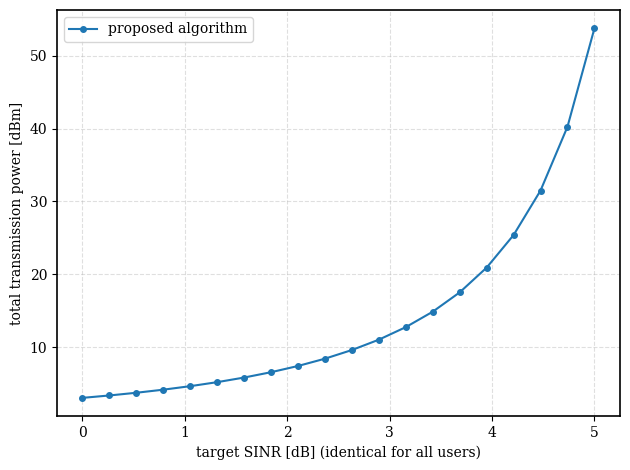

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# plt.figure(figsize=(6,4), dpi=150)

plt.plot(
    target_sinr_db_list,
    p_opt_sum_list,
    marker='o',
    linestyle='-',
    linewidth=1.5,
    markersize=4,
    label='proposed algorithm'
)

# 3) 그래프 꾸미기 (논문 스타일 비슷하게)
plt.xlabel('target SINR [dB] (identical for all users)')
plt.ylabel('total transmission power [dBm]')
plt.grid(True, linestyle='--', alpha=0.4)

# 범례: 논문에서는 원형(o) = proposed, + = conventional, 삼각형 = single antenna
# 우리는 지금은 proposed만 있으니까 일단 이것만
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()